# Prepare files

In [21]:
# unfortunately I don't have API key for using python API directly so let's download manually
import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
from cmapPy.pandasGEXpress import parse
import os
if not os.path.exists('data/'):
    os.makedirs('data/')

#download lvl5 perturbation data
pert_path = '/tank/projects/kriukov_cmap/level5_beta_trt_cp_n720216x12328.gctx'   #<--- PLEASE, put your path to perturbation file here
#if not this file
#!wget "https://s3.amazonaws.com/macchiato.clue.io/builds/LINCS2020/level5/level5_beta_trt_cp_n720216x12328.gctx"

#download cmap genes
!wget -P data/  "https://s3.amazonaws.com/macchiato.clue.io/builds/LINCS2020/geneinfo_beta.txt"
#download cmap compounds
!wget -P data/ "https://s3.amazonaws.com/macchiato.clue.io/builds/LINCS2020/compoundinfo_beta.txt"
#download signatures info
!wget -P data/ "https://s3.amazonaws.com/macchiato.clue.io/builds/LINCS2020/siginfo_beta.txt"

--2022-09-27 09:42:03--  https://s3.amazonaws.com/macchiato.clue.io/builds/LINCS2020/geneinfo_beta.txt
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.99.118
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.99.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1141389 (1.1M) [text/plain]
Saving to: ‘data/geneinfo_beta.txt.1’

geneinfo_beta.txt.1 100%[===================>]   1.09M  1.52MB/s    in 0.7s    

2022-09-27 09:42:04 (1.52 MB/s) - ‘data/geneinfo_beta.txt.1’ saved [1141389/1141389]

--2022-09-27 09:42:05--  https://s3.amazonaws.com/macchiato.clue.io/builds/LINCS2020/compoundinfo_beta.txt
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.99.118
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.99.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4631014 (4.4M) [text/plain]
Saving to: ‘data/compoundinfo_beta.txt.1’

compoundinfo_beta.t 100%[===================>]   4.42M  3.09MB/s    in 1.4s    

20

In [1]:
genes = pd.read_csv('./data/geneinfo_beta.txt', sep='\t', index_col=0)
comps = pd.read_csv('./data/compoundinfo_beta.txt', sep='\t', index_col=0)
signs = pd.read_csv('./data/siginfo_beta.txt', sep='\t', index_col='sig_id', low_memory=False)

In [191]:
#extract landmark genes and n compounds for the following analysis and time/memory economy
n = 15 #number of top compounds - this number may decrease after filtering

lm = genes[genes.feature_space == 'landmark']
lm.index = lm.index.astype(str)
top_compounds_by_pert_count = signs.groupby('pert_id')['pert_id'].count().sort_values(ascending=False).index[:n].tolist()
cp = comps.loc[comps.index.intersection(top_compounds_by_pert_count)]
#filter signatures
sg = signs[signs.pert_id.isin(cp.index)]
sg = sg[sg.is_hiq == 1] #only high quality samples in the analysis
sg = sg.loc[sg[['pert_itime', 'pert_idose', 'cell_iname']].dropna(axis=0).index]
#preprocess features
sg['TIME'] = np.log2(sg.pert_itime.str.split(' ', expand=True)[0].astype(float))
sg['DOSE'] = np.log10(sg.pert_idose.str.split(' ', expand=True)[0].astype(float))

print("%d unique compounds left after filtration." % sg.pert_id.unique().shape[0])

12 unique compounds left after filtration.


In [192]:
# parse gene expression table (may take several minutes)
df = parse.parse(pert_path, rid=lm.index, cid=sg.index).data_df

# Data harmonization

## Model-intercept based approach

In [320]:
#data harmonization procedure
# from statsmodels.stats.multitest import multipletests
# import statsmodels.api as sm
# from patsy import dmatrices
# from scipy.stats import combine_pvalues
# from tqdm import tqdm
# from multiprocessing import Pool

# itable = pd.DataFrame(columns=lm.index, index=sg.pert_id.unique()) #table for appending intercept values gene expression
# ptable = pd.DataFrame(columns=lm.index, index=sg.pert_id.unique()) #same for pvalue

# pool = Pool(40) 
# for c in tqdm(sg.pert_id.unique()):
#     tmp = sg[sg.pert_id==c]
#     factors = tmp[['TIME', 'DOSE', 'cell_iname']]
#     c_data = df[tmp.index]
    
#     def fit_expression_one_intercept(g):
#         y = c_data.loc[g]
#         y.name = 'expression'
#         design = pd.merge(y, factors, left_index=True, right_index=True)
#         y, X = dmatrices('expression ~ TIME + DOSE + cell_iname', data=design, return_type='dataframe')
#         mod = sm.OLS(y, X) 
#         OLS_result = mod.fit()
#         return OLS_result.params['Intercept'], OLS_result.pvalues['Intercept']

#     pool_g_result = pool.map(fit_expression_one_intercept, lm.index.tolist())
#     itable.loc[c], ptable.loc[c] = list(zip(*pool_g_result))

In [216]:
#data harmonization procedure
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
from patsy import dmatrices
from scipy.stats import combine_pvalues
from tqdm import tqdm
from multiprocessing import Pool

itable = pd.DataFrame(columns=lm.index, index=sg.pert_id.unique()) #table for appending intercept values gene expression
ptable = pd.DataFrame(columns=lm.index, index=sg.pert_id.unique()) #same for pvalue

def fit_expression_one_intercept(arg):
    c, g = arg
    tmp = sg[sg.pert_id==c]
    factors = tmp[['TIME', 'DOSE', 'cell_iname']]
    c_data = df[tmp.index]
    y = c_data.loc[g]
    y.name = 'expression'
    design = pd.merge(y, factors, left_index=True, right_index=True)
    y, X = dmatrices('expression ~ TIME + DOSE + cell_iname', data=design, return_type='dataframe')
    mod = sm.OLS(y, X) 
    OLS_result = mod.fit()
    return OLS_result.params['Intercept'], OLS_result.pvalues['Intercept']

pairs = [(c, g) for c in sg.pert_id.unique() for g in lm.index.tolist()]
pool = Pool(40) 
pool_g_result = pool.map(fit_expression_one_intercept, pairs)

#fill tables
for (c, g), (i, p) in zip(pairs, pool_g_result):
    itable.loc[c, g] = i
    ptable.loc[c, g] = p

Despite the parallel call of the function `fit_expression_one_intercept`, this solution still remains the performance 
bottleneck of the whole analysis. The possible solution could lie in avoiding slow python loop within the function. 
It can be achieved by using R pipeline for DE analysis instead of python one, for instance with `limma` package.

In [231]:
#aggregate pvalues with stouffer z-score method, and apply multiple test to exclude ambiguous compounds
agg_pval = [combine_pvalues(ptable.iloc[i].tolist(), method='stouffer')[1] for i in range(ptable.shape[0])]
passed_compounds = multipletests(agg_pval, method='fdr_bh', alpha=0.05)[0]
itable_final = itable[passed_compounds].astype(float)

In [290]:
# itable = itable.astype(float)
# for i in itable.index:
#     tmp = df.loc[itable.columns, sg[sg.pert_id == i].index]
#     print(i, tmp.corrwith(itable.loc[i], axis=0).mean())

In [291]:
#just look at the resulting table
itable_final

#this is a harmonized dataset prepared for the following analysis

gene_id,16,23,25,30,39,47,102,128,142,154,178,207,211,226,230,291,310,323,329,332,348,351,355,387,392,427,466,481,501,533,572,581,595,596,622,637,642,644,652,664,665,670,672,695,701,727,780,808,813,823,...,66008,79006,79071,79073,79080,79090,79094,79143,79170,79174,79187,79600,79643,79716,79850,79902,79921,79947,79961,80204,80212,80347,80349,80746,80758,81533,81544,83743,84159,84617,84722,84890,85236,85377,89910,90861,91137,91949,93487,93594,94239,116832,124583,147179,148022,200081,200734,256364,375346,388650
BRD-K81418486,-2.826018,-2.286712,-1.897774,2.326226,3.427604,1.389320,-1.466952,1.933214,-1.445518,2.962661,0.152530,0.676004,3.348231,-1.130693,0.799979,-0.884427,2.028431,0.172169,-1.280543,2.571498,-1.023281,-1.277278,0.529914,-0.671366,-1.462606,0.172552,-5.691402,1.967457,-1.938340,0.616148,1.461728,-0.408238,-1.945393,-0.906010,1.945976,0.009508,-0.937761,1.642682,0.053226,2.756557,3.203604,-1.207799,0.154548,0.373477,-0.461731,2.146457,-0.733592,-1.314542,0.509501,0.220107,...,1.654984,-1.410185,0.370687,-2.277382,0.527886,0.051166,-0.919807,1.044615,0.482889,-0.535059,-2.864103,-0.802969,-0.781243,1.590519,-3.360797,2.670182,2.215131,1.949891,1.121354,-0.431700,0.575368,-2.754075,0.739030,-0.270858,-1.371452,-0.415644,-0.373814,-1.949298,2.387072,-1.585446,0.999660,-1.969954,-2.917911,-1.429166,-0.375177,-1.470592,-1.676747,-2.202519,-2.526113,0.944114,0.084508,0.231056,0.077383,1.536844,-0.877120,-2.581570,-0.830289,-1.150718,1.306732,-0.513815
BRD-K21680192,1.060822,-2.702418,-0.301852,0.308257,-0.152705,1.076980,1.536088,-2.755125,1.450404,1.174950,0.512637,1.132839,-4.409352,1.218407,0.278565,1.820588,-0.031118,-1.115150,-0.522513,3.267737,-0.106148,-1.463282,2.066370,1.335231,0.425678,-0.712998,1.485604,-0.172130,0.062366,-0.489754,-0.092415,0.084923,0.645833,3.068950,0.240493,-0.253273,1.481752,2.730077,0.283827,1.984756,0.860246,-0.660390,1.064013,0.705572,-1.190148,2.059974,0.614228,-1.035156,0.101566,-0.597226,...,0.647195,0.987521,3.287968,-0.635183,2.205706,-0.713473,-0.342366,-2.804299,-0.642886,1.239328,-1.807041,1.177421,1.462882,-0.702249,-1.459242,-0.164041,0.108688,-3.391048,0.901467,0.847658,0.969765,0.224612,-0.700211,1.361950,0.505681,-0.946302,1.529836,0.901545,-1.140194,0.466089,-2.274670,2.138089,-1.056711,1.741704,2.727817,1.258670,-1.248270,0.187150,-2.600631,2.494906,-2.010975,0.770505,-3.384664,-2.798946,-3.386010,-0.126200,-1.335700,-0.266828,-1.226043,-0.893117
BRD-A75409952,3.128850,-1.550881,-3.188456,-0.754895,0.436587,0.236069,1.989639,-1.225848,-4.822476,-0.546263,-0.752764,-0.397193,-1.650512,0.228412,-1.956894,-4.312627,2.162358,2.389855,1.674567,3.726701,-1.022829,0.259790,0.385147,4.228259,-0.288631,-1.285528,1.665504,-0.373120,-0.144133,-0.622730,-2.645866,-2.647491,-3.628079,1.051196,-2.043955,-0.698009,-0.426389,-0.305469,-1.027989,1.876285,7.776901,-0.478152,1.941608,-1.444041,0.278063,-0.754983,0.505093,-0.699298,-1.729904,-0.775709,...,1.783316,-1.367865,-1.904352,-5.537483,-4.724865,-2.492744,-0.493333,-1.352610,0.029586,-1.604137,-1.370271,1.620118,-1.744462,-1.978229,-1.261987,-3.050064,-1.901181,-0.913458,-0.482227,-0.502366,-0.422946,-2.020582,-1.913488,-2.106572,-2.960497,-1.699166,1.993476,-2.475433,0.150936,0.678677,1.982909,-2.492125,0.352190,3.049010,0.088264,2.467250,1.009188,-0.526737,-1.933118,1.787943,0.738284,1.708113,-1.095854,0.881736,0.262780,-2.797445,-0.767756,-2.649373,0.266211,-1.323401
BRD-A19037878,-4.084303,-2.447400,-3.936585,2.055870,3.595893,-1.165413,-0.968756,1.441076,-2.425898,5.455878,0.526854,1.815909,5.519206,-1.275415,4.738781,-1.928292,2.213146,-0.113437,-1.919853,1.949643,-0.265298,-0.051362,-0.379710,1.203964,-3.170299,0.639618,-6.477730,2.046264,-2.105091,-0.173781,3.698072,-0.667870,-2.548219,-1.761906,1.888529,-0.125127,-1.828717,2.278820,0.834376,5.160199,6.995293,-1.160450,-1.773537,0.030551,-0.281351,2.811842,1.042038,-0.789982,0.804004,1.630596,...,3.664539,-1.370760,0.964096,-1.654917,-0.266049,1.322823,-0.486983,2.636663,0.

## Naive approach

In [316]:
#naive harmonization approach: just average all signatures with the same pert_id
itable_naive = df.T.loc[sg.index].groupby(sg.pert_id).mean()

# Similarity analysis

In [318]:
#here we get pubchem similarity matrix
from rdkit import Chem
from rdkit import DataStructs

smiles = comps.loc[itable_final.index, 'canonical_smiles'].unique().tolist()
mols = [Chem.MolFromSmiles(m) for m in smiles]
fps = [Chem.RDKFingerprint(x) for x in mols]

sim = pd.DataFrame(0, columns=itable_final.index, index=itable_final.index)
for i in range(len(sim)):
    for j in range(i, len(sim)):
        sim.iloc[i,j] = sim.iloc[j,i] = DataStructs.FingerprintSimilarity(fps[i], fps[j])

cor = itable_final.T.corr(method='pearson')

In [319]:
m = cor.shape[0]
ridx,cidx = np.triu_indices(m, 1)

np.corrcoef(cor.to_numpy()[ridx, cidx], sim.to_numpy()[ridx, cidx])

array([[1.        , 0.42269809],
       [0.42269809, 1.        ]])

In [296]:
import seaborn as sns

In [106]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [123]:
X = df.T.loc[sg[sg.pert_id.isin(['BRD-K49328571', 'BRD-K51313569'])].index]

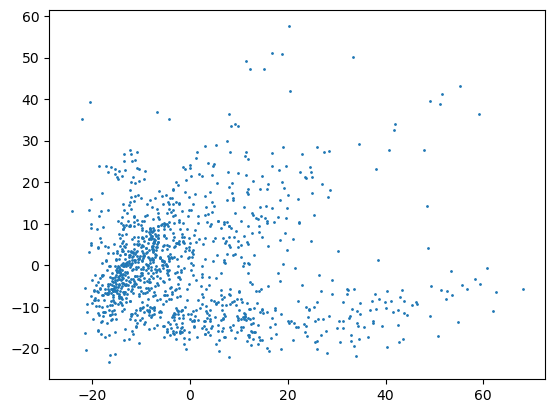

In [125]:
Xp = PCA(2).fit_transform(X)

plt.scatter(Xp[:, 0], Xp[:, 1], s=1)

rid,10007,1001,10013,10038,10046,10049,10051,10057,10058,10059,10099,10112,10123,10131,10146,10150,10153,10165,1017,10174,10180,1019,10190,102,10206,1021,1022,10221,10227,10237,10245,1026,1027,10270,10273,10276,10285,1029,10298,10318,10320,10329,10362,10398,10434,10450,10451,10489,10491,10493,...,9533,9552,958,960,9637,9641,965,9650,9653,9670,9686,9688,9690,9695,9697,9702,9703,9709,9710,9712,9738,976,9761,9797,9801,9805,9813,9817,983,9833,9842,9847,9851,9854,9868,9897,9903,991,9915,9917,9918,9924,9926,9928,993,994,9943,9961,998,9988
cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ABY001_A375_XH:BRD-K74514084:0.625:24,-0.832428,1.190877,1.260821,0.253233,0.740723,0.076396,-0.181747,0.441436,0.923459,-0.052517,-0.331420,-0.018397,-0.471101,-0.030561,-2.737713,0.378183,-0.395771,0.444807,0.721117,-0.101882,0.355888,1.230759,-0.120287,0.622424,-0.238426,0.262658,0.866551,-1.320621,0.745371,-0.554033,0.793409,-0.068762,-0.149189,-0.577133,-0.454884,-0.877415,1.151845,0.507753,-0.051304,0.056659,3.390989,0.781602,-4.677936,-1.272684,-1.223436,-0.618355,1.056052,-0.127303,-0.932780,-1.946556,...,-0.596380,-0.591139,0.676179,1.099918,-0.464690,-0.842793,-0.015701,-0.127208,-0.446064,-0.598471,-0.213712,1.049628,1.297265,-0.360846,-0.185783,0.046854,0.068773,-0.400003,-0.364804,5.401845,0.451411,1.962910,0.081797,-0.644846,-0.930334,0.299111,-0.036367,-0.301388,-0.214214,0.459759,-0.595735,-2.908267,-0.511545,-0.211569,-0.556269,-1.200178,0.610208,1.326216,-0.061212,0.945602,-0.929870,0.872174,0.112396,0.012145,0.567729,0.862075,-0.482947,-1.249774,0.938644,0.251364
ABY001_A375_XH:BRD-K74514084:10:24,1.940605,-0.565400,-0.681389,-0.761948,-0.190798,-0.559039,-0.670819,0.485710,-0.615472,-0.891772,-0.209658,-1.888599,0.584025,-0.925605,-0.347352,-0.726735,-0.546028,1.027589,0.698507,-0.276985,2.542549,0.250912,-1.945380,-0.865716,-0.476899,-0.848841,-0.227910,-0.517386,0.775394,-0.129541,-0.624615,1.060176,0.008067,-0.546934,0.672880,-0.185528,-0.410060,-0.292699,0.450139,-1.857940,-0.465459,1.224068,-0.786838,-0.462544,-0.197829,0.626364,-0.359979,0.350276,0.216856,2.631227,...,-0.378823,0.495014,0.516269,0.146746,0.073552,0.290147,0.325975,0.186611,0.379456,-0.004973,0.190453,-1.436316,-0.279101,0.025473,-0.445876,1.650702,-0.451611,0.617998,0.295102,0.777124,-0.235001,0.135097,-0.264360,-1.174167,-0.811143,0.964414,0.063142,-0.883914,-0.291439,0.211582,-0.103787,-0.550748,0.409378,-0.070414,-0.968095,0.068684,-0.371881,-4.295455,-0.191029,-0.026884,-1.048393,0.282483,0.346332,-0.302119,-0.810021,0.538173,0.685156,-0.673909,-0.612878,-0.266476
ABY001_A375_XH:BRD-K74514084:10:3,-0.497215,-0.610160,1.286175,1.012454,1.653604,-0.663753,0.568403,-0.227967,0.815315,-0.161418,0.543991,0.770203,-1.292502,0.637511,0.039651,-1.507993,-1.576149,0.438566,-0.032045,-0.841404,0.877712,0.941353,0.067837,-0.019504,-0.497391,-0.108719,0.764852,-0.134991,-0.498385,0.104636,-0.882315,-0.989413,-0.089381,-1.241780,0.301418,-0.276713,-0.143400,-0.691884,0.341385,0.465035,-1.163267,0.206748,0.431687,0.123071,-0.466978,0.878593,-0.371602,0.133356,0.196122,0.195324,...,-1.730223,0.762000,-0.072333,-0.276964,-0.166323,-0.350127,0.058670,-0.638971,-0.294964,-0.947805,-0.979884,0.897417,-0.687674,-0.460336,0.223233,-0.276696,-0.397108,1.664590,0.595150,0.390573,0.130059,0.544093,0.339811,-0.954456,-0.030609,-0.078724,-0.817865,-1.764356,-0.210836,0.276838,0.086060,0.019343,-0.303554,0.149986,0.000391,-0.134568,-0.787336,0.402828,-0.333785,0.342085,0.733575,1.118000,0.885846,0.726416,-0.414596,0.442852,-0.154119,0.559992,-0.681602,0.238317
ABY001_A375_XH:BRD-K74514084:2.5:24,-0.104782,-0.070379,1.517367,0.667274,0.107885,0.263165,-0.454387,-0.307922,0.015914,-0.163362,0.231508,0.780678,-0.109589,-0.667763,-3.680135,-0.577874,-0.927497,-0.191341,1.302854,-1.533412,0.809539,0.949083,-1.647541,1.028504,-1.113707,-0.451092,-0.268227,-0.700939,-0.509210,-0.905286,-0.140546,-0.033812,0.476129,-0.523478,1.015216